<a href="https://colab.research.google.com/github/hilmidemir/pytorch-zero-to-hero/blob/main/Transfer_Learning_Last_Project_Hilmi_Demir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Kurulum Aşaması


In [ ]:
# Bu proje için gerekli Torch ve torchvision kütüphanelerini ekliyoruz
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision sürümleri gerekli olanla aynı değil, güncel sürümleri kuruyor.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision sürümleri gerekli olanla aynı değil, güncel sürümleri kuruyor.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.4.0+cu121
torchvision version: 0.19.0+cu121


In [ ]:
# Gerekli diğer kütüphaneleri ekliyoruz
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

try:
    from going_modular.going_modular import data_setup, engine
except:
    # going_modular komut dosyalarını ekliyorum
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/hilmidemir/pytorch-zero-to-hero
    !mv pytorch-zero-to-hero/modules .
    !rm -rf pytorch-zero-to-hero
    from modules import data_setup, engine

[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-zero-to-hero'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 30 (delta 10), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (30/30), 15.19 MiB | 10.65 MiB/s, done.
Resolving deltas: 100% (10/10), done.
mv: cannot move 'pytorch-zero-to-hero/modules' to './modules': Directory not empty


Eğer cuda

In [ ]:
# cihaz seçme ve kullanılan cihazı görüntülemek için
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 2. Datasetleri yükleme

In [ ]:
import os
import zipfile

from pathlib import Path

import requests

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# Eğer resim dosyası yoksa indir ve hazırla
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Pizza, steak, sushi verisini indirdik
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/hilmidemir/pytorch-zero-to-hero/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Pizza, steak, sushi verisini zipten çıkardık
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

data/pizza_steak_sushi directory exists.


In [ ]:
# Test ve train pathlerini oluşturduk
train_dir = image_path / "train"
test_dir = image_path / "test"

In [ ]:
# manuel olarak bir pipeline oluşturduk.
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Bütün görselleri 224x224 olacak şekilde düzenledik (Bazı modellerde bu boyutlar değişiklik gösterebilir.)
    transforms.ToTensor(), # 2. Görüntü verilerini bir pytorch tensorune dönüştürdük (tensorler hesaplamalar için daha verimli ve pytorch ile daha uyumludur.)
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # 3. Görüntü verilerini normalleştirdik. Normalleştirme, görüntü verilerinin ortalama değerini sıfıra
                         std=[0.229, 0.224, 0.225]) # ve standart sapmasını bire yaklaştırır. Kullandığımız değerler ImageNet in hesapladığı değerlerdir.
])

In [ ]:
# train ve testloaderlerı oluşturduk
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms, # resimleri boyutlandırdık ve öğremme modeli için uygun hale getirdik.
                                                                               batch_size=32) # mini-batch sizeını 32 ye ayarladık.

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7c6bf889b580>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
# Önceden eğitilmiş model weightlerinden yararlanacağız
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = ImageNet'te pretraining ile alınmış en iyi mevcut ağırlıklar
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [ ]:
# Önceden eğitilmiş ağırlıklarımızı oluşturmak için kullanılan dönüşümleri aldık.
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms,
                                                                               batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7c6bf889bb20>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
# Cihazı pretraind weightler ile kurup cihaza geri gönderiyoruz
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = kullanılabilecek en iyi weight
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

#model

In [ ]:
summary(model=model,
        input_size=(32, 3, 224, 224), # input size olacakmış input shape değil
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [ ]:
for param in model.features.parameters():
    param.requires_grad = False

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# class sayısını aldık.
output_shape = len(class_names)

# Classifier katmanını yeniden oluşturduk ve hedef cihaza yayınladık.
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # Class sayımızla aynı olması gerekiyor.
                    bias=True)).to(device)

In [ ]:
# Özellikleri dondurduktan ve çıkış sınıflandırıcı katmanını değiştirdikten sonra tekrar summary
summary(model,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [ ]:
# loss function ve optimizer tanımlıyoruz.
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Manual seeed tanımlıyoruz.
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Timer kurduk.
from timeit import default_timer as timer
start_time = timer()

# eğitim aşamamızı kurduk ve sonuçları kaydettik
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# timer durdurduk ve ne kadar sürdüğünü gördük.
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9133 | test_acc: 0.5398
Epoch: 2 | train_loss: 0.8717 | train_acc: 0.7773 | test_loss: 0.7912 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.7930 | test_loss: 0.7463 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7109 | train_acc: 0.7539 | test_loss: 0.6373 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6255 | train_acc: 0.7852 | test_loss: 0.6261 | test_acc: 0.8561
[INFO] Total training time: 21.188 seconds


In [ ]:
import matplotlib.pyplot as plt  # Matplotlib'i plt adıyla import ediyoruz

# helper_functions.py'dan plot_loss_curves() fonksiyonunu aldık
try:
    from helper_functions import plot_loss_curves
except ImportError:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    import requests
    request = requests.get("https://raw.githubusercontent.com/hilmidemir/pytorch-zero-to-hero/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Modelimizin loss eğrilerini çizdiriyoruz.
plot_loss_curves(results)

NameError: name 'plt' is not defined

In [ ]:
from typing import List, Tuple

from PIL import Image

# 1. Eğitilmiş modeli, class name, image path, image size, a transform ve target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):


    # 2. image'ı açtık.
    img = Image.open(image_path)

    # 3. Yoksa görüntü için transform oluşturduk.
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Resim üzerinde predict aşamamız ###

    # 4. Modelin doğru cihazda olduğuna emin olduk.
    model.to(device)

    # 5. Inferance ve evaluation modunu açtık.
    model.eval()
    with torch.inference_mode():
      # 6. Görüntyü dönüştürdük ve ekstra bir dimension ekledik (format olarak: [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Eksta dimensiona sahip görsel üzerinde tahmin yaptık ve cihaza gönderdik.
      target_image_pred = model(transformed_image.to(device))

    # 8.  logit değerlerini tahmin olasılıklarına dönüştürdük (torch.softmax(), multi-class classification için kullanılır.)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. prediction olasılıklarını prediction labellerine dönüştürdük.
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Görünütyü predicted label ve olasılığıyla çizdirdik.
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

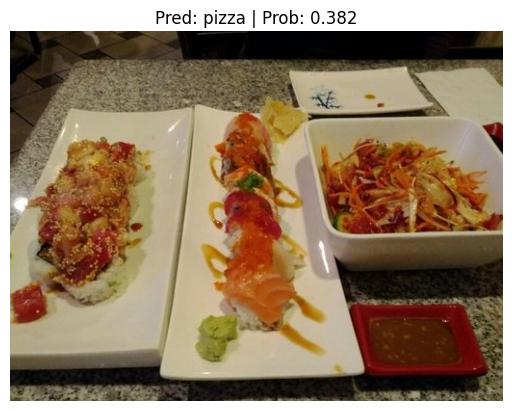

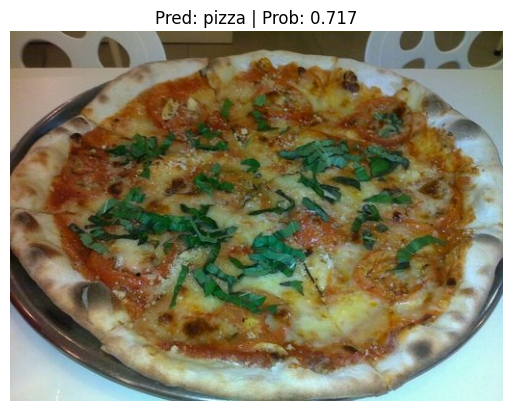

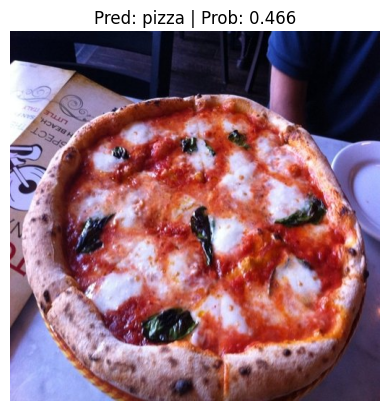

In [ ]:
# Test setimizden rastgele resimlerin pathlerini aldık.
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # test verilerinden tüm resimlerin yollarını listeledik
test_image_path_sample = random.sample(population=test_image_path_list, # listeden belirlediğimiz sayıda rastgele örnek seçer ve bunlarla
                                       k=num_images_to_plot)            # yeni bir liste oluşturduk.

# Resşimler üzerinde tahminlerde bulunduk ve yeniden grafiğini çizdik.
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # isteğe bağlı olarak, önceden eğitilmiş model ağırlıklarımızdan belirli bir dönüşümü iletebiliriz
                        image_size=(224, 224))

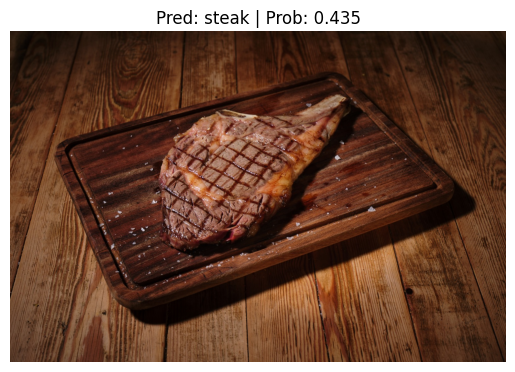

In [ ]:
import requests

# Seçtiğimiz resmin yolunu verdik
custom_image_path = data_path / "04-kral-steak.jpeg"

# Resim yoksa indirmesini istedik
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # Githubdan indirirken raw dosyasının linkini vermemiz gerekiyor.
        request = requests.get("https://www.elbetsteakhouse.com.tr/wp-content/uploads/2021/09/elbet_14047.jpg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Resmimizin üzerinden tahminde bulunuyor
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)